In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #Biểu đồ 3 chiều
import seaborn as sns

import datetime
from scipy import stats
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
data=pd.read_excel('/content/drive/MyDrive/Customer-Segmentation.xlsx')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


**Giải thích dữ liệu:**

*Các trường dữ liệu trên liên quan đến việc quản lý đơn hàng của doanh nghiệp, cụ thể:*

**InvoiceNo:** Mã đơn hàng

**StockCode:** Mã sản phẩm

**Description:** Mô tả chi tiết về sản phẩm được *bán*

**Quantity:** Số lượng của sản phẩm

**InvoiceDate:** Thời điểm mà đơn hàng được bán

**UnitPrice:** Đơn giá của mỗi đơn vị sản phẩm

**CustomerID:** Mã định danh của khách hàng

**Country:** Quốc gia mà đơn hàng được thực hiện

In [ ]:
#Kiểm tra các trường thông tin có dòng nào bị NaN không
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

**Nhận xét:** *Trong tất cả các dòng dữ liệu trên, ta thấy mục Description không quan trọng (Do chỉ là mô tả sản phẩm, có hay không đều được). Duy có phần Customer ID là có ảnh hưởng tới mô hình tính toán RFM. Vì vậy ta nên loại bỏ đi tất cả các dòng dữ liệu không có CustomerID. tức là dữ liệu hiện tại còn khoảng 541909-135080=406289 dòng*

In [ ]:
# Loại bỏ bớt các cột mang giá trị NaN đã nói ở trên
data_cut = data[data['CustomerID'].notna()]

#Lấy ngẫu nhiên 10000 mẫu dữ liệu cho nhanh
data_new = data_cut.sample(10000, random_state=42)
data_new.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,2011-01-07 12:14:00,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,2011-09-15 13:51:00,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,2011-08-03 10:10:00,0.85,12921.0,United Kingdom


In [ ]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 47912 to 282657
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    10000 non-null  object        
 1   StockCode    10000 non-null  object        
 2   Description  10000 non-null  object        
 3   Quantity     10000 non-null  int64         
 4   InvoiceDate  10000 non-null  datetime64[ns]
 5   UnitPrice    10000 non-null  float64       
 6   CustomerID   10000 non-null  float64       
 7   Country      10000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 703.1+ KB


**Tính Skewness**

**Tính toán RFM**

**Mục Recency:** Ban đầu, ta cần chuyển đổi kiểu dữ liệu của phần ngày tháng sang kiểu dữ liệu Datetime, nếu dữ liệu đó đã có dạng Datetime rồi thì không cần nữa.

In [ ]:
#Lấy ngày lớn nhất trong dữ liệu, cộng thêm 1 ngày
current_date = max(data_new['InvoiceDate']) + datetime.timedelta(days=1)

#Tính Monetary = Số lượng x Đơn giá
data_new['TotalPay'] = data_new['Quantity'] * data_new['UnitPrice']

#Group lại để tính RFM
data_customers = data_new.groupby(['CustomerID']).agg(
    {'InvoiceDate': lambda x: (current_date- x.max()).days,
     'InvoiceNo':'count',
     'TotalPay':'sum'
     }
)

In [ ]:
#Đổi tên cột cho trực quan hơn
data_customers.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPay':'MonetaryValue'}, inplace=True)
data_customers.head(3)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,39,5,133.20
12348.0,249,2,120.88
12349.0,19,2,312.75


In [ ]:
# Tính skewness hiện tại cho từng cột của bộ dữ liệu
skewness_recency = skew(data_customers['Recency'])
skewness_frequency = skew(data_customers['Frequency'])
skewness_monetary_value = skew(data_customers['MonetaryValue'])

print("Skewness của cột Recency:", skewness_recency)
print("Skewness của cột Frequency:", skewness_frequency)
print("Skewness của cột MonetaryValue:", skewness_monetary_value)

Skewness của cột Recency: 0.9334272937284889
Skewness của cột Frequency: 14.756935378512852
Skewness của cột MonetaryValue: 16.617298124054752


**Nhận xét về Skewness:**

**Recency=0.933:** Độ méo lệch về phía bên phải, một số lượng lớn các giao dịch có Recency < trung bình, và một số lượng nhỏ hơn các giao dịch có Recency > trung bình.

**Frequency=14.757:** Phân phối có độ méo lệch rất lớn về phía bên phải, một số lượng lớn các khách hàng có tần suất mua hàng rất thấp, trong khi có một số lượng nhỏ các khách hàng có tần suất mua hàng rất cao.

**MonetaryValue=16.617:** Phân phối có độ méo lệch rất lớn về phía bên phải, một số lượng lớn các giao dịch có giá trị tiền mặt thấp, trong khi có một số lượng nhỏ các giao dịch có giá trị tiền mặt rất cao.

<ipython-input-7-ecabe3272558>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_customers['Recency'], ax = ax[0])
<ipython-input-7-ecabe3272558>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_customers['Frequency'], ax = ax[1])
<ipython-input-7-ecabe3272558>:5: UserWarning: 

`distpl

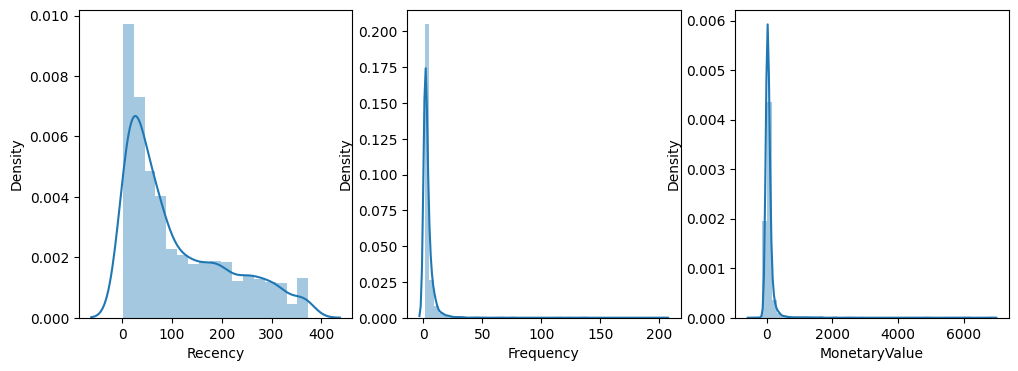

In [ ]:
#vẽ biểu đồ phân phối
fig, ax = plt.subplots(1, 3, figsize=(12,4))
sns.distplot(data_customers['Recency'], ax = ax[0])
sns.distplot(data_customers['Frequency'], ax = ax[1])
sns.distplot(data_customers['MonetaryValue'], ax = ax[2])
plt.show()

**Hàm tính toán Skewness ban đầu và tính toán khi khi ta thực hiện lần lượt 3 phép Transformation (Log, Square root, Box-Cox). Sau đó vẽ kết quả ra biểu đồ:**


In [ ]:
def analyze_skewness(x):
    #Vẽ biểu đồ
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(data_customers[x], ax=ax[0,0])
    sns.distplot(np.log(data_customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(data_customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(data_customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

    print(data_customers[x].skew().round(2))  #Tinh Skewness ban đầu
    print(np.log(data_customers[x]).skew().round(2))  #Tinh Skewness dùng hàm Log
    print(np.sqrt(data_customers[x]).skew().round(2)) #Tinh Skewness với hàm Căn bậc 2
    print(pd.Series(stats.boxcox(data_customers[x])[0]).skew().round(2))  #Tinh Skewness với hàm Box cox

<ipython-input-10-adecb1a4531e>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_customers[x], ax=ax[0,0])
<ipython-input-10-adecb1a4531e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(data_customers[x]), ax=ax[0,1])
<ipython-input-10-adecb1a4531e>:6: UserWarning: 

`distplot` is 

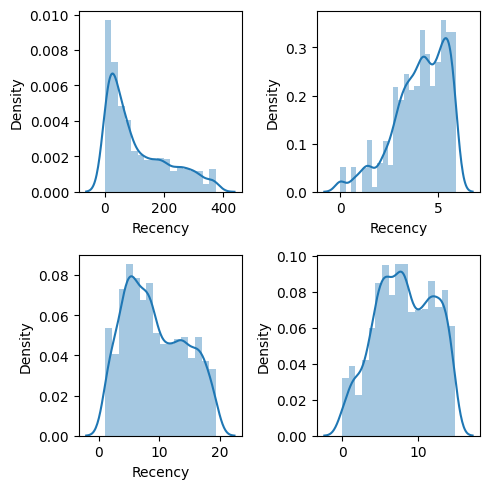

0.93
-0.83
0.31
-0.11


In [ ]:
#Tính Skewness cho cột Recency (Tương tự với 2 cột còn lại)
analyze_skewness('Recency')

<ipython-input-10-adecb1a4531e>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_customers[x], ax=ax[0,0])
<ipython-input-10-adecb1a4531e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(data_customers[x]), ax=ax[0,1])
<ipython-input-10-adecb1a4531e>:6: UserWarning: 

`distplot` is 

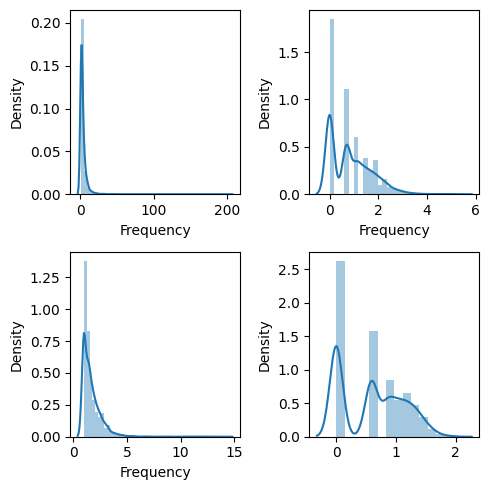

14.77
0.85
3.67
0.16


In [ ]:
analyze_skewness('Frequency')

***NOTE:** Trong trường hợp này, phần dữ liệu "MonetaryValue" không phù hợp để tính với 3 hàm Log, Square root, Boxcox do có giá trị âm. Vì vậy, ta sẽ tính "MonetaryValue" theo hàm Căn bậc 3 (Cube root)


**Từ biểu đồ trên, ta thấy: Khi sử dụng Cox-box thì giá trị Skewness về gần 0 nhất. Còn MonetaryValue thì ta sẽ áp dụng Cube root**

In [ ]:
#Chuyển đổi dữ liệu bằng Cox-box và Cube root
data_customers_t = pd.DataFrame() #Tạo ra một dataframe mới với các giá trị của nó được tính từ các giá trị của data_customer
data_customers_t['Recency'] = stats.boxcox(data_customers['Recency'])[0]
data_customers_t['Frequency'] = stats.boxcox(data_customers['Frequency'])[0]
data_customers_t['MonetaryValue'] = pd.Series(np.cbrt(data_customers['MonetaryValue'])).values
data_customers_t.head(5)

,Recency,Frequency,MonetaryValue
0,6.285050,1.127547,5.107026
1,12.822038,0.591193,4.944452
2,4.514540,0.591193,6.787853
3,8.093846,1.127547,4.324076
4,12.507538,0.591193,3.217225


In [ ]:
#Sử dụng Standard Scaler cho dữ liệu
scaler = StandardScaler()
scaler.fit(data_customers_t)

data_customers_t = scaler.transform(data_customers_t)

In [ ]:
pd.DataFrame(data_customers_t).head(5)

,0,1,2
0,-0.496913,1.012426,1.017503
1,1.234593,-0.017412,0.925115
2,-0.965883,-0.017412,1.972690
3,-0.017802,1.012426,0.572565
4,1.151289,-0.017412,-0.056441


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

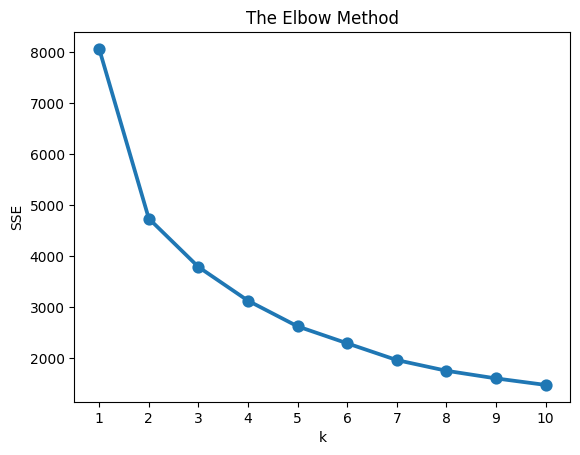

In [ ]:
#Phương pháp Elbow để tính số cụm phù hợp cho Kmeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_customers_t)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()


**Như vậy, Kmeans với k=3**

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(data_customers_t)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [ ]:
data_customers['Cluster'] = model.labels_
data_customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,39,5,133.20,0
12348.0,249,2,120.88,2
12349.0,19,2,312.75,0
12352.0,72,5,80.85,0
12354.0,232,2,33.30,2


In [ ]:
#Nhóm các giá trị dữ liệu theo từng Cluster tương ứng và tính trung bình của mỗi cluster đó theo 3 giá trị R, F, M
data_customers.groupby('Cluster').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'MonetaryValue':'mean'
    }
).round(3) #Làm tròn 2 chữ số thập phân


,Recency,Frequency,MonetaryValue
Cluster,,,
0,45.589,7.709,165.795
1,46.883,1.611,21.509
2,226.538,1.644,28.699


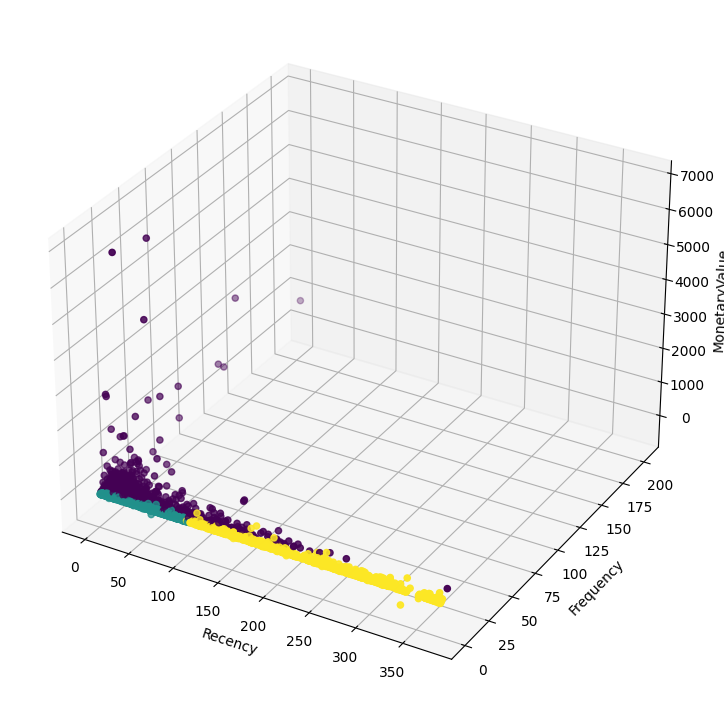

In [ ]:
#Vẽ thử biểu đồ xem phân phối của 3 cluster như thế nào
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Vẽ biểu đồ scatter 3D
ax.scatter(data_customers['Recency'], data_customers['Frequency'], data_customers['MonetaryValue'], c=data_customers['Cluster'], cmap='viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

plt.show()